<a href="https://colab.research.google.com/github/yualapshina/ml-lab2/blob/master/ml_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import copy
import random
import csv

In [2]:
SEED = 88

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. обработка данных

In [3]:
!git clone https://github.com/yualapshina/ml-lab2.git --quiet

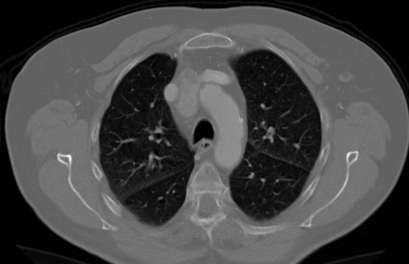

In [18]:
train_data = datasets.ImageFolder(root='ml-lab2/train/train')
test_data = datasets.ImageFolder(root='ml-lab2/test')
train_data[0][0]
# можно было бы привести к одному каналу вместо трёх благодаря чб,
# но предобученные модели всё равно принимают три, так что ладно

In [19]:
max_w, max_h = 0, 0
for image, _ in data.ConcatDataset([train_data, test_data]):
    if image.size[0] > max_w:
        max_w = image.size[0]
    if image.size[1] > max_h:
        max_h = image.size[1]
print(max_w, max_h)

1200 874


In [20]:
min_w, min_h = 1000, 1000
for image, _ in data.ConcatDataset([train_data, test_data]):
    if image.size[0] < min_w:
        min_w = image.size[0]
    if image.size[1] < min_h:
        min_h = image.size[1]
print(min_w, min_h)

168 110


In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((min_w, min_h)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((min_w, min_h)),
    transforms.ToTensor(),
    ])

In [22]:
train_data = datasets.ImageFolder(root='ml-lab2/train/train', transform=train_transforms)
test_data = datasets.ImageFolder(root='ml-lab2/test', transform=test_transforms)

In [23]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [24]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# 2. сбор собственной модели

In [83]:
class MyNet(nn.Module):
    def __init__(self, output_dim = 4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(15360, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [26]:
def accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [27]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if model.__class__.__name__ == 'MyNet':
            y_pred, _ = model(x)
        else:
            y_pred = model(x)

        loss = criterion(y_pred, y)
        acc = accuracy(y_pred, y)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            if model.__class__.__name__ == 'MyNet':
                y_pred, _ = model(x)
            else:
                y_pred = model(x)

            loss = criterion(y_pred, y)
            acc = accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            if model.__class__.__name__ == 'MyNet':
                y_pred, _ = model(x)
            else:
                y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [31]:
classes = {
    0: 'adenocarcinoma',
    1: 'large.cell.carcinoma',
    2: 'normal',
    3: 'squamous.cell.carcinoma',
}

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss().to(device)

In [85]:
model = MyNet()
sum(p.numel() for p in model.parameters() if p.requires_grad)

64339332

In [86]:
optimizer = optim.Adam(model.parameters())
model = model.to(device)

In [87]:
EPOCHS = 50
best_valid_loss = 100000
max_stale_iter = 3

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    print(f"EPOCH {epoch}")
    print(f"TRAIN LOSS: {train_loss}, TRAIN ACC: {train_acc}")
    print(f"VALID LOSS: {valid_loss}, VALID ACC: {valid_acc}")

    if best_valid_loss > valid_loss:
        best_valid_loss = valid_loss
        stale_iter = 0
    elif max_stale_iter == stale_iter:
        break
    else:
        stale_iter += 1

EPOCH 0
TRAIN LOSS: 1.663546363512675, TRAIN ACC: 0.27874598900477093
VALID LOSS: 1.3753303289413452, VALID ACC: 0.3188405930995941


EPOCH 1
TRAIN LOSS: 1.3921262820561726, TRAIN ACC: 0.30088141063849133
VALID LOSS: 1.3683098554611206, VALID ACC: 0.3188405930995941


EPOCH 2
TRAIN LOSS: 1.3712013562520344, TRAIN ACC: 0.3142027258872986
VALID LOSS: 1.36672842502594, VALID ACC: 0.3188405930995941


EPOCH 3
TRAIN LOSS: 1.3553327719370525, TRAIN ACC: 0.31800881028175354
VALID LOSS: 1.3259040117263794, VALID ACC: 0.3188405930995941


EPOCH 4
TRAIN LOSS: 1.310455083847046, TRAIN ACC: 0.31039663155873615
VALID LOSS: 1.2495170831680298, VALID ACC: 0.3188405930995941


EPOCH 5
TRAIN LOSS: 1.1952458222707112, TRAIN ACC: 0.37900640567143756
VALID LOSS: 1.1026740074157715, VALID ACC: 0.52173912525177


EPOCH 6
TRAIN LOSS: 1.0806294679641724, TRAIN ACC: 0.5187299648920695
VALID LOSS: 1.0117648839950562, VALID ACC: 0.52173912525177


EPOCH 7
TRAIN LOSS: 1.0123393734296162, TRAIN ACC: 0.5277443925539652
VALID LOSS: 1.132619857788086, VALID ACC: 0.49275362491607666


EPOCH 8
TRAIN LOSS: 0.9904466470082601, TRAIN ACC: 0.5267427861690521
VALID LOSS: 1.012542963027954, VALID ACC: 0.4637681245803833


EPOCH 9
TRAIN LOSS: 0.9657527804374695, TRAIN ACC: 0.532852570215861
VALID LOSS: 1.0107800960540771, VALID ACC: 0.5507246255874634


EPOCH 10
TRAIN LOSS: 0.9495905836423238, TRAIN ACC: 0.5842347741127014
VALID LOSS: 0.9614913463592529, VALID ACC: 0.47826087474823


EPOCH 11
TRAIN LOSS: 0.9267629583676656, TRAIN ACC: 0.5298477609952291
VALID LOSS: 0.9194996356964111, VALID ACC: 0.5942028760910034


EPOCH 12
TRAIN LOSS: 0.9077931443850199, TRAIN ACC: 0.616286059220632
VALID LOSS: 0.9046907424926758, VALID ACC: 0.5507246255874634


EPOCH 13
TRAIN LOSS: 0.8755776683489481, TRAIN ACC: 0.5702123443285624
VALID LOSS: 0.9049617648124695, VALID ACC: 0.5507246255874634


EPOCH 14
TRAIN LOSS: 0.8576803604761759, TRAIN ACC: 0.5620993574460348
VALID LOSS: 0.8757134079933167, VALID ACC: 0.5942028760910034


EPOCH 15
TRAIN LOSS: 0.8238569299379984, TRAIN ACC: 0.6293068925539652
VALID LOSS: 0.858205258846283, VALID ACC: 0.5942028760910034


EPOCH 16
TRAIN LOSS: 0.8201214472452799, TRAIN ACC: 0.6004607280095419
VALID LOSS: 0.8484178185462952, VALID ACC: 0.5797101259231567


EPOCH 17
TRAIN LOSS: 0.7980408271153768, TRAIN ACC: 0.6437299648920695
VALID LOSS: 0.8348001837730408, VALID ACC: 0.6086956262588501


EPOCH 18
TRAIN LOSS: 0.7956852118174235, TRAIN ACC: 0.6153846184412638
VALID LOSS: 0.9014691114425659, VALID ACC: 0.5652173757553101


EPOCH 19
TRAIN LOSS: 0.7746190230051676, TRAIN ACC: 0.6353165109952291
VALID LOSS: 0.8048016428947449, VALID ACC: 0.6811594367027283


EPOCH 20
TRAIN LOSS: 0.7784805695215861, TRAIN ACC: 0.674178679784139
VALID LOSS: 0.8003911375999451, VALID ACC: 0.6376811861991882


EPOCH 21
TRAIN LOSS: 0.7465428312619528, TRAIN ACC: 0.6800881425539652
VALID LOSS: 0.809110164642334, VALID ACC: 0.6376811861991882


EPOCH 22
TRAIN LOSS: 0.7380502621332804, TRAIN ACC: 0.6712740461031595
VALID LOSS: 0.7610219120979309, VALID ACC: 0.6666666865348816


EPOCH 23
TRAIN LOSS: 0.6556928753852844, TRAIN ACC: 0.7276642719904581
VALID LOSS: 0.7455633282661438, VALID ACC: 0.695652186870575


EPOCH 24
TRAIN LOSS: 0.6285914977391561, TRAIN ACC: 0.7383814056714376
VALID LOSS: 0.7591953277587891, VALID ACC: 0.6666666865348816


EPOCH 25
TRAIN LOSS: 0.6245118180910746, TRAIN ACC: 0.73828125
VALID LOSS: 0.7045369744300842, VALID ACC: 0.7101449370384216


EPOCH 26
TRAIN LOSS: 0.5867147843043009, TRAIN ACC: 0.7595152258872986
VALID LOSS: 0.7453157901763916, VALID ACC: 0.695652186870575


EPOCH 27
TRAIN LOSS: 0.5654454231262207, TRAIN ACC: 0.7668269276618958
VALID LOSS: 0.6691210269927979, VALID ACC: 0.7246376872062683


EPOCH 28
TRAIN LOSS: 0.5561447739601135, TRAIN ACC: 0.7611177961031595
VALID LOSS: 0.6371005177497864, VALID ACC: 0.7246376872062683


EPOCH 29
TRAIN LOSS: 0.5189773539702097, TRAIN ACC: 0.787459929784139
VALID LOSS: 0.6596084237098694, VALID ACC: 0.739130437374115


EPOCH 30
TRAIN LOSS: 0.5175300439198812, TRAIN ACC: 0.7655248443285624
VALID LOSS: 0.5980292558670044, VALID ACC: 0.7101449370384216


EPOCH 31
TRAIN LOSS: 0.4964112937450409, TRAIN ACC: 0.799879809220632
VALID LOSS: 0.6630832552909851, VALID ACC: 0.7681159377098083


EPOCH 32
TRAIN LOSS: 0.46919124325116474, TRAIN ACC: 0.8042868574460348
VALID LOSS: 0.5528687834739685, VALID ACC: 0.739130437374115


EPOCH 33
TRAIN LOSS: 0.43860378861427307, TRAIN ACC: 0.818709929784139
VALID LOSS: 0.6542826294898987, VALID ACC: 0.7101449370384216


EPOCH 34
TRAIN LOSS: 0.4385937452316284, TRAIN ACC: 0.7933693925539652
VALID LOSS: 0.5195404291152954, VALID ACC: 0.7971014380455017


EPOCH 35
TRAIN LOSS: 0.4087187647819519, TRAIN ACC: 0.8175080219904581
VALID LOSS: 0.5250405669212341, VALID ACC: 0.8260869383811951


EPOCH 36
TRAIN LOSS: 0.3668701748053233, TRAIN ACC: 0.8600761294364929
VALID LOSS: 0.5074324607849121, VALID ACC: 0.8115941882133484


EPOCH 37
TRAIN LOSS: 0.3712761302789052, TRAIN ACC: 0.8509615461031595
VALID LOSS: 0.5100394487380981, VALID ACC: 0.8115941882133484


EPOCH 38
TRAIN LOSS: 0.35013020038604736, TRAIN ACC: 0.8496594627698263
VALID LOSS: 0.4908340573310852, VALID ACC: 0.7971014380455017


EPOCH 39
TRAIN LOSS: 0.30772436658541363, TRAIN ACC: 0.8807091315587362
VALID LOSS: 0.4564562141895294, VALID ACC: 0.8115941882133484


EPOCH 40
TRAIN LOSS: 0.3584084709485372, TRAIN ACC: 0.844651440779368
VALID LOSS: 0.5185559391975403, VALID ACC: 0.7971014380455017


KeyboardInterrupt: 

In [88]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels_mynet = torch.argmax(probs, 1)

In [89]:
# пересортировка из-за алфавитного порядка файлов
n_test = len(pred_labels_mynet)
pred_labels_sorted = [0] * n_test
for i in range(n_test):
    ind = int(test_data.imgs[i][0][18:-4])
    pred_labels_sorted[ind] = int(pred_labels_mynet[i])

In [90]:
with open('ml-lab2/submit.csv','w') as output:
    writer = csv.writer(output, delimiter=',')
    writer.writerow(['ID', 'label'])
    for i in range(len(pred_labels_mynet)):
        writer.writerow([i, classes[pred_labels_sorted[i]]])

In [91]:
submit = pd.read_csv('ml-lab2/submit.csv')
submit

,ID,label
0,0,normal
1,1,normal
2,2,adenocarcinoma
3,3,normal
4,4,normal
...,...,...
310,310,squamous.cell.carcinoma
311,311,normal
312,312,squamous.cell.carcinoma
313,313,squamous.cell.carcinoma


# 3. предобученная модель

In [80]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [81]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 4)
model = model.to(device)
optimizer = optim.Adam(model.parameters())

In [82]:
EPOCHS = 100000
best_valid_loss = 100000
max_stale_iter = 3

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    print(f"EPOCH {epoch}")
    print(f"TRAIN LOSS: {train_loss}, TRAIN ACC: {train_acc}")
    print(f"VALID LOSS: {valid_loss}, VALID ACC: {valid_acc}")

    if best_valid_loss > valid_loss:
        best_valid_loss = valid_loss
        stale_iter = 0
    elif max_stale_iter == stale_iter:
        break
    else:
        stale_iter += 1

EPOCH 0
TRAIN LOSS: 1.3932243585586548, TRAIN ACC: 0.4045472741127014
VALID LOSS: 1.280740737915039, VALID ACC: 0.43478259444236755


EPOCH 1
TRAIN LOSS: 1.07440984249115, TRAIN ACC: 0.5020032028357188
VALID LOSS: 1.0544012784957886, VALID ACC: 0.5507246255874634


EPOCH 2
TRAIN LOSS: 0.9511794845263163, TRAIN ACC: 0.5983573794364929
VALID LOSS: 1.018785834312439, VALID ACC: 0.5362318754196167


EPOCH 3
TRAIN LOSS: 0.8762943545977274, TRAIN ACC: 0.6309094627698263
VALID LOSS: 1.0659300088882446, VALID ACC: 0.5797101259231567


EPOCH 4
TRAIN LOSS: 0.8625500798225403, TRAIN ACC: 0.6164863705635071
VALID LOSS: 1.0479631423950195, VALID ACC: 0.5942028760910034


EPOCH 5
TRAIN LOSS: 0.8213377594947815, TRAIN ACC: 0.6146834890047709
VALID LOSS: 1.0208700895309448, VALID ACC: 0.6086956262588501


EPOCH 6
TRAIN LOSS: 0.8016656239827474, TRAIN ACC: 0.659254809220632
VALID LOSS: 1.0054737329483032, VALID ACC: 0.5652173757553101


EPOCH 7
TRAIN LOSS: 0.8096062342325846, TRAIN ACC: 0.6587540109952291
VALID LOSS: 0.9900473952293396, VALID ACC: 0.6086956262588501


EPOCH 8
TRAIN LOSS: 0.7765313188234965, TRAIN ACC: 0.6350160241127014
VALID LOSS: 1.0592072010040283, VALID ACC: 0.5507246255874634


EPOCH 9
TRAIN LOSS: 0.7619702617327372, TRAIN ACC: 0.6811898946762085
VALID LOSS: 1.0360572338104248, VALID ACC: 0.5797101259231567


EPOCH 10
TRAIN LOSS: 0.774786651134491, TRAIN ACC: 0.6689703464508057
VALID LOSS: 1.001426100730896, VALID ACC: 0.6086956262588501


EPOCH 11
TRAIN LOSS: 0.7407279014587402, TRAIN ACC: 0.6667668223381042
VALID LOSS: 1.0262528657913208, VALID ACC: 0.5797101259231567


In [79]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels_alexnet = torch.argmax(probs, 1)

n_test = len(pred_labels_alexnet)
pred_labels_sorted = [0] * n_test
for i in range(n_test):
    ind = int(test_data.imgs[i][0][18:-4])
    pred_labels_sorted[ind] = int(pred_labels_alexnet[i])

with open('ml-lab2/submit.csv','w') as output:
    writer = csv.writer(output, delimiter=',')
    writer.writerow(['ID', 'label'])
    for i in range(len(pred_labels_alexnet)):
        writer.writerow([i, classes[pred_labels_sorted[i]]])